In [1]:
%matplotlib widget

import edrixs
import numpy as np
import scipy as sp
from scipy.sparse import csr_array
import matplotlib.pyplot as plt
import pickle
from timeit import default_timer as de_time

import os
from glob import glob as globf
import shutil

import sys
sys.path.append("..")
from importlib import reload
#import utils
#reload(utils)
#from utils import plot_image, load_var, save_var, make_theme, turbo_w

In [2]:
from matplotlib import rcParams

rcParams['font.size'] = 7
rcParams['lines.linewidth'] = 1
rcParams['lines.markersize'] = 3
rcParams['axes.labelsize'] = 7
rcParams['axes.labelpad'] = 1
rcParams['axes.linewidth']= 0.7
rcParams['ytick.minor.width']= 0.5
rcParams['figure.titlesize']= 9
rcParams['legend.fontsize']= 7
rcParams['legend.frameon']= False
rcParams['legend.handletextpad']= 0.2
rcParams['legend.markerscale']= 1.2
rcParams['xtick.labelsize']= 6
rcParams['ytick.labelsize']= 6
rcParams['xtick.major.size']= 3
rcParams['ytick.major.size']= 3
rcParams['xtick.major.pad']= 3
rcParams['ytick.major.pad']= 3
rcParams['xtick.major.width']= 0.7
rcParams['ytick.major.width']= 0.7
rcParams['xtick.minor.size']= 1.7
rcParams['ytick.minor.size']= 1.7
rcParams['xtick.minor.pad']= 2.8
rcParams['ytick.minor.pad']= 2.8
rcParams['xtick.minor.width']= 0.6
rcParams['ytick.minor.width']= 0.6

rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'
rcParams['xtick.top']=True
rcParams['ytick.right']=True

# Set up the Hamiltonian

In [3]:
# Set the number of d electrons, and orbitals
nd = 3
norb_d = 10
norb_bath = 10
nbath = 1
v_noccu  = nd + nbath*norb_d
shell_name = ('d', 'p') # valence and core shells for XAS calculation

In [4]:
# Get the atomic values for the Slater and SOC parameters
info  = edrixs.utils.get_atom_data('Cr', '3d', nd, edge='L3')
zeta_d_i = info['v_soc_i'][0]
zeta_d_n = info['v_soc_n'][0]
c_soc = info['c_soc']

In [5]:
# Set the adjustable parameters
U_dd = 4
U_dp = 6

ten_dq = .2
Delta = 0
scale_dd = 0.72
scale_dp = 0.5

# Compute the Slater parameters we will be using
F2_dd_i = info['slater_i'][1][1] * scale_dd
F4_dd_i = info['slater_i'][2][1] * scale_dd
F0_dd_i = U_dd + edrixs.get_F0('d', F2_dd_i, F4_dd_i)

F2_dd_n = info['slater_n'][1][1] * scale_dd
F4_dd_n = info['slater_n'][2][1] * scale_dd
F0_dd_n = U_dd + edrixs.get_F0('d', F2_dd_n, F4_dd_n)


F2_dp = info['slater_n'][4][1] * scale_dp
G1_dp = info['slater_n'][5][1] * scale_dp
G3_dp = info['slater_n'][6][1] * scale_dp
F0_dp = U_dp + edrixs.get_F0('dp', G1_dp, G3_dp)

slater = ([F0_dd_i, F2_dd_i, F4_dd_i],  # initial
          [F0_dd_n, F2_dd_n, F4_dd_n, F0_dp, F2_dp, G1_dp, G3_dp])  # with core hole

In [6]:
# Hopping matrix which is output from Julia
twoferm = np.array([ [3.201, 0, 0, 0, 0, -2.426, 0, 0, 0, 0], 
                     [0, 3.227, 0.0147, 0, 0, 0, -2.313, -0.15, 0, 0],
                     [0, 0.0147, 2.662, 0, 0, 0, 0.159, -1.49, 0, 0],
                     [0, 0, 0, 2.733, -0.041, 0, 0, 0, -1.383, -0.068], 
                     [0, 0, 0, -0.041, 2.733, 0, 0, 0, -0.068, -1.383], 
                     [-2.426, 0, 0, 0, 0, 1.573, 0, 0, 0, 0], 
                     [0, -2.313, 0.159, 0, 0, 0, 1.56, 0.211, 0, 0], 
                     [0, -0.15, -1.49, 0, 0, 0, 0.211, -0.181, 0, 0], 
                     [0, 0, 0, -1.383, -0.068, 0, 0, 0, 0.0096, -0.061], 
                     [0, 0, 0, -0.068, -1.383, 0, 0, 0, -0.061, 0.0096] ] )

# Take into account the fact that the orbitals are listed in a different order than in edRIXS
basis_change = np.array([[0, 0, 0, 1, 0],
                        [1, 0, 0, 0, 0],
                        [0, 0, 0, 0, 1], 
                        [0, 1, 0, 0, 0], 
                        [0, 0, 1, 0, 0]])
bc = sp.linalg.block_diag(basis_change, basis_change)
H_MO = bc.transpose().dot(twoferm.dot(bc ) )

In [10]:
# Set up the two fermion matrices for the initial and intermdiate states
hopping_i = np.zeros((20,20), dtype=complex)
hopping_n = np.zeros((20,20), dtype=complex)

# Crystal field parameter
deg = ten_dq 
hopping_i_temp = H_MO + np.diag([deg, 0, 0, deg, 0, 0, 0, 0, 0, 0, ])
hopping_n_temp = H_MO + np.diag([deg, 0, 0, deg, 0, 0, 0, 0, 0, 0, ])

# Offsets to the ligand and d levels taking into account U and Delta
E_d, E_L = edrixs.CT_imp_bath(U_dd, Delta, nd)
E_dc, E_Lc, E_p = edrixs.CT_imp_bath_core_hole(U_dd, U_dp, Delta, nd)

## d onsite
hopping_i_temp[:5,:5] += np.diag([E_d]*5)
## d onsite with a core hole
hopping_n_temp[:5,:5] += np.diag([E_dc ]*5)
## L onsite
hopping_i_temp[5:,5:] += np.diag([E_L ]*5)
## L onsite with a core hole
hopping_n_temp[5:,5:] += np.diag([E_Lc ]*5)

hopping_i[0:20:2,0:20:2] += hopping_i_temp
hopping_i[1:20:2,1:20:2] += hopping_i_temp
hopping_n[0:20:2,0:20:2] += hopping_n_temp
hopping_n[1:20:2,1:20:2] += hopping_n_temp

## Add SOC
hopping_i[:10,:10] += edrixs.cb_op(edrixs.atom_hsoc('d', zeta_d_i), edrixs.tmat_c2r('d', True))
hopping_n[:10,:10] += edrixs.cb_op(edrixs.atom_hsoc('d', zeta_d_n), edrixs.tmat_c2r('d', True))

message = ("U_dd = {:.3f} eV\n"
           "U_dp = {:.3f} eV\n"
           "E_p = {:.3f} eV\n"
          )
print(message.format(U_dd, U_dp, E_p))

U_dd = 4.000 eV
U_dp = 6.000 eV
E_p = -15.158 eV



In [11]:
ext_B = np.array([0.00, 0.00, 0.044/3])
print(ext_B) # Vector of external magnetic field with respect to global `xyz`-axis.
on_which = 'spin'

[0.         0.         0.01466667]


In [12]:
trans_c2n = edrixs.tmat_c2r('d',True)
om_shift = 576.3
c_level = -om_shift - 5*E_p - 0.0

# Diagonalize the Hamiltonian using the Fortran solver

In [13]:
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
print('rank: ' + str(rank))
print('size: ' + str(size))

rank: 0
size: 1


In [14]:
siam_type = 1 # General hybridization function, including off-diagonal terms
do_ed = 1 # Only do ED for given occupancy number *v_noccu*, return eigenvalues and density matrix, write eigenvectors to files eigvec.n
ed_solver=2 # use parallel version of Arpack library to find a few lowest eigenvalues, it is accurate and is the recommeded choice in real calculations of XAS and RIXS.
neval=200 # Number of eigenvalues to be found. For ed_solver=2, the value should not be too small, neval > 10 is usually a safe value.
ncv=300 # Used for ed_solver=2, it should be at least ncv > neval + 2. Usually, set it a little bit larger than neval, for example, set ncv=200 when neval=100.
nvector=neval # Number of eigenvectors to be found and written into files.
idump=True # Whether to dump the eigenvectors to files "eigvec.n", where n means the n-th vectors.

start_time = de_time()
eval_i, denmat, noccu_gs = edrixs.ed_siam_fort(
    comm, shell_name, nbath, siam_type=siam_type, hopping=hopping_i, hopping_n=hopping_n, 
    c_level=c_level, c_soc=c_soc, slater=slater, ext_B=ext_B,
    on_which=on_which, trans_c2n=trans_c2n, v_noccu=v_noccu, do_ed=do_ed,
    ed_solver=ed_solver, neval=neval, nvector=nvector, ncv=ncv, idump=idump)
end_time = de_time()
print("It took {:.0f} s to complete.".format(end_time-start_time))

edrixs >>> Running ED ...

    Summary of Slater integrals:
    ------------------------------
    Terms,  Initial Hamiltonian,  Intermediate Hamiltonian
     F0_vv :          4.4007314286        4.4312228571
     F2_vv :          7.7594400000        8.3491200000
     F4_vv :          4.8636000000        5.2344000000
     F0_vc :          0.0000000000        6.2179285714
     F2_vc :          0.0000000000        3.2630000000
     G1_vc :          0.0000000000        2.3940000000
     G3_vc :          0.0000000000        1.3610000000
     F0_cc :          0.0000000000        0.0000000000
     F2_cc :          0.0000000000        0.0000000000

edrixs >>> do_ed=1, perform ED at noccu:  13
 --------------------------------------------
  fedrixs >>> ED begin ... 

     num_val_orbs:               20
     ed_solver:                   2
     neval:                     200
     nvector:                   200
     maxiter:                  1000
     min_ndim:                 1000
     ncv:     

# Determine the properties of the calculated eigenvectors

In [15]:
def get_fortran_eigvec(eigvec_num):
    f = open('eigvec.'+str(eigvec_num), 'rb')
    dt = np.dtype(np.complex128)
    ffile  = np.fromfile( f, dtype=dt, offset = 4)
    eigval = ffile[0:1].real[0] # first complex  number is the eigenvalue
    v_for  = ffile[1:]          # the rest of complex number are the eigenvector values
    f.close()
    return v_for

def decimalToBinary(n, norb):
    binstr = bin(int(n)).replace("0b", "")
    binlen = len(binstr)
    binlist = []
    for i in range(norb):
        if i < binlen:
            binlist.append(int(binstr[-1-i]))
        else:
            binlist.append(0)
    return binlist

def get_fortran_fock_i(norb):
    dec_arr = np.loadtxt('fock_i.in', dtype='int')[1:]
    fock_i = []
    for dec in dec_arr:
        fock_i.append(decimalToBinary(dec, norb))
    return fock_i

def rixs_analysis_new(eval_i, denmat):
    '''The evaluation of <S^2> is done in the full basis using scipy sparse matrix'''
    # Convert density matrix from complex spherical harmonics basis to real spherical harmonics basis
    tmat = sp.linalg.block_diag(edrixs.tmat_c2r('d',True), edrixs.tmat_c2r('d',True))
    denmat_r = edrixs.cb_op(denmat, tmat)

    neval = denmat_r.shape[0]
    evals = (eval_i-eval_i[0])[0:neval]

    # Get orbital occupancies
    d_eg = denmat_r.diagonal(axis1=1,axis2=2)[:,[0,1,6,7]].sum(axis=1).real
    d_t2g = denmat_r.diagonal(axis1=1,axis2=2)[:,[2,3,4,5,8,9]].sum(axis=1).real
    L_eg = denmat_r.diagonal(axis1=1,axis2=2)[:,[10,11,16,17]].sum(axis=1).real
    L_t2g = denmat_r.diagonal(axis1=1,axis2=2)[:,[12,13,14,15,18,19]].sum(axis=1).real
   
    # S and L operators
    spin_mom_Cr = np.zeros((3, 20, 20), dtype=complex)
    spin_mom_Cr[:, :10, :10] = edrixs.get_spin_momentum(2)

    orb_mom_Cr = np.zeros((3, 20, 20), dtype=complex)
    orb_mom_Cr[:, :10, :10] = edrixs.get_orb_momentum(2, ispin=True)

    # Extract basis and eigenvectors
    basis_i = np.array(get_fortran_fock_i(norb=20))
    evecs_i = []
    for i in range(neval):
        evecs_i.append(get_fortran_eigvec(eigvec_num=i+1))
    evecs_i = np.array(evecs_i).T
    evecs_i = csr_array(evecs_i)

    # Compute spin operators
    Sx_Cr = edrixs.two_fermion(spin_mom_Cr[0], basis_i)
    Sx_Cr = csr_array(Sx_Cr)
    Sx2_Cr = Sx_Cr @ Sx_Cr   
    Sy_Cr = edrixs.two_fermion(spin_mom_Cr[1], basis_i)
    Sy_Cr = csr_array(Sy_Cr)
    Sy2_Cr = Sy_Cr @ Sy_Cr   
    Sz_Cr = edrixs.two_fermion(spin_mom_Cr[2], basis_i)
    Sz_Cr = csr_array(Sz_Cr)
    Sz2_Cr = Sz_Cr @ Sz_Cr
    S2_Cr = Sx2_Cr + Sy2_Cr + Sz2_Cr

    # Spin states for eigenvectors
    S2_Cr_val = (np.conj(np.transpose(evecs_i)) @ S2_Cr @ evecs_i).toarray().diagonal().real
    Sz_Cr_val = (np.conj(np.transpose(evecs_i)) @ Sz_Cr @ evecs_i).toarray().diagonal().real

    # Compute orbital angular momentum operators
    Lx_Cr = edrixs.two_fermion(orb_mom_Cr[0], basis_i)
    Lx_Cr = csr_array(Lx_Cr)
    Lx2_Cr = Lx_Cr @ Lx_Cr    
    Ly_Cr = edrixs.two_fermion(orb_mom_Cr[1], basis_i)
    Ly_Cr = csr_array(Sy_Cr)
    Ly2_Cr = Sy_Cr @ Sy_Cr   
    Lz_Cr = edrixs.two_fermion(orb_mom_Cr[2], basis_i)
    Lz_Cr = csr_array(Lz_Cr)
    Lz2_Cr = Lz_Cr @ Lz_Cr   
    L2_Cr = Lx2_Cr + Ly2_Cr + Lz2_Cr

    # Orbital states for eigenvectors
    L2_Cr_val = (np.conj(np.transpose(evecs_i)) @ L2_Cr @ evecs_i).toarray().diagonal().real
    Lz_Cr_val = (np.conj(np.transpose(evecs_i)) @ Lz_Cr @ evecs_i).toarray().diagonal().real

    rixs_ana_results = dict(evals=evals, L2_Cr_val=L2_Cr_val, Lz_Cr_val=Lz_Cr_val, 
                            S2_Cr_val=S2_Cr_val, Sz_Cr_val=Sz_Cr_val, 
                            d_eg=d_eg, d_t2g=d_t2g, L_eg=L_eg, L_t2g=L_t2g)   
    return rixs_ana_results

In [16]:
# Calculate the properties of the calculated eigenvectors

start_time = de_time()
rixs_ana_results = rixs_analysis_new(eval_i, denmat)
end_time = de_time()
print("It took {:.0f} s to complete.".format(end_time-start_time))

It took 288 s to complete.


# Calculate the XAS

In [17]:
# Set the parameters for the XAS scan

ominc_xas = om_shift + np.linspace(-2, 14, 100)
temperature = 30
num_gs = 2 # Number of initial states used in XAS calculations.
nkryl = 200 # Maximum number of poles obtained.

thin = np.deg2rad(45)
tth = np.deg2rad(90)
thout = tth - thin
phi = np.deg2rad(0)
gamma_c = 0.6 # Core-hole life-time broadening factor

poltype_xas = [('linear', 0), ('linear', np.pi/2)] # ['LH', 'LV']
scatter_axis = np.array([[1*2**-0.5,0,1*2**-0.5],[1*2**-0.5,0,-1*2**-0.5],[0,1,0]])  #sample geometry

In [18]:
# Calculate XAS using the Fortran function
start_time = de_time()
xas, xas_poles = edrixs.xas_siam_fort(
    comm, shell_name, nbath, ominc_xas, gamma_c=gamma_c, v_noccu=v_noccu, thin=thin,
    phi=phi, num_gs=num_gs, nkryl=nkryl, pol_type=poltype_xas, temperature=temperature, 
    scatter_axis=scatter_axis, 
)
end_time = de_time()
print("It took {:.0f} s to complete.".format(end_time-start_time))

edrixs >>> Running XAS ...
edrixs >>> Loop over for polarization:  0 linear
 ---------------------------
  fedrixs >>> XAS Begin ... 


     num_val_orbs:               20
     num_core_orbs:               6
     ndim_i:                  77520
     ndim_n:                 232560
     nhopp_n:                   122
     ncoul_n:                   932
     num_gs:                      2
     nkryl:                     200

  fedrixs >>> For ground state:            1
     Building transition operator for absorption process ...
     Done !

     Apply transition operator on the ground state to get intermediate state...
     Done !

     Build Hamiltonian for intermediate configuration...
     Allocate memory for ham_csr ...
     Really building Hamiltonian begin here ...
     Number of nonzero elements of intermediate Hamiltonian:               7291392
     Done !

     Building Krylov space for XAS spectrum ...
     Krylov iteration:     50
     Krylov iteration:    100
     Krylov itera

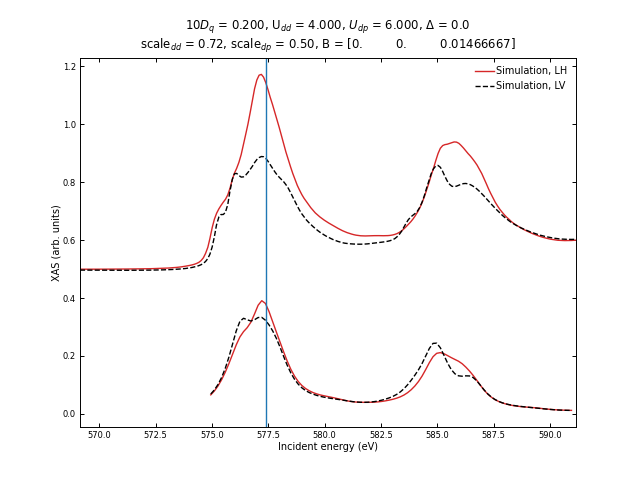

In [19]:
# Plot the XAS to check that the offset eshift is correct

fig, ax = plt.subplots()
eshift = .65
ax.plot(ominc_xas+eshift, xas[:,0], color='C3', ls='-', lw=1, label='Simulation, LH')
ax.plot(ominc_xas+eshift, xas[:,1], color='k', ls='--', lw=1, label='Simulation, LV')

ax.legend()
ax.set_xlabel('Incident energy (eV)')
ax.set_ylabel('XAS (arb. units)')
# ax.set_title('Anderson impurity model for CrI3')
title = '10$D_q$ = {:.3f}, U$_{{dd}}$ = {:.3f}, $U_{{dp}}$ = {:.3f}, $\Delta$ = {:.1f}\nscale$_{{dd}}$ = {:.2f}, scale$_{{dp}}$ = {:.2f}, B = {}'.format(ten_dq, U_dd, U_dp, Delta, scale_dd, scale_dp,  ext_B)
ax.set_title(title)

fl = np.load('xas_lh.npz')
ax.plot(fl['ein'], (fl['xas']-fl['xas'][0])/(fl['xas'][-1]-fl['xas'][0])/10+0.5, color='C3', ls='-', lw=1, label='Data, $\\pi$-pol.')
fl = np.load('xas_lv.npz')
ax.plot(fl['ein'], (fl['xas']-fl['xas'][0])/(fl['xas'][-1]-fl['xas'][0])/10+0.5, color='k', ls='--', lw=1, label='Data, $\\sigma$-pol.')

ax.set_xlim(569.15, 591.15)
ax.axvline(x=577.4)
plt.show()

# Calculate the RIXS spectrum

In [20]:
# Set the parameters for the scan

ominc_rixs = np.array([577.4]) - eshift
eloss = np.linspace(-1, 3.4, 800)
temperature = 30
num_gs = 2 # Number of initial states used in XAS calculations.
nkryl = 200 # Maximum number of poles obtained.

thin = np.deg2rad(15)
tth = np.deg2rad(90)
thout = tth - thin
phi = np.deg2rad(0)

gamma_c = 0.6 # The core-hole life-time broadening factor.
gamma_f = 0.030 # The final states life-time broadening factor.

poltype_rixs_lh = [('linear', 0, 'linear', 0), ('linear', 0, 'linear', np.pi/2)] # 'LH'
poltype_rixs_lv = [('linear', np.pi/2, 'linear', 0), ('linear', np.pi/2, 'linear', np.pi/2)] # 'LV'
scatter_axis = np.array([[1*2**-0.5,0,1*2**-0.5],[1*2**-0.5,0,-1*2**-0.5],[0,1,0]]) # sample geometry

In [21]:
# Helper function

def cal_rixs1(eval_i, ominc, eloss, temperature, comm, shell_name, nbath, gamma_c, gamma_f, v_noccu, thin, thout, phi, num_gs, nkryl, pol_type, scatter_axis):
    start_time = de_time()
    rixs, poles = edrixs.rixs_siam_fort(
        comm=comm, shell_name=shell_name, nbath=nbath, ominc=ominc, eloss=eloss, gamma_c=gamma_c, gamma_f=gamma_f, v_noccu=v_noccu, thin=thin, 
        thout=thout, phi=phi, num_gs=num_gs, nkryl=nkryl, pol_type=pol_type, temperature=temperature,
        scatter_axis=scatter_axis, 
    )
    end_time = de_time()
    print("It took {:.0f} s to complete.".format(end_time-start_time))
    return np.sum(rixs, axis=2), poles

# Calculate the RIXS spectra
rixs_lh = cal_rixs1(eval_i=eval_i, ominc=ominc_rixs, eloss=eloss, temperature=temperature, 
                            comm=comm, shell_name=shell_name, nbath=nbath, gamma_c=gamma_c, gamma_f=gamma_f, 
                            v_noccu=v_noccu, thin=thin, thout=thout, phi=phi, num_gs=num_gs, nkryl=nkryl, 
                            pol_type=poltype_rixs_lh, scatter_axis=scatter_axis)
rixs_lv = cal_rixs1(eval_i=eval_i, ominc=ominc_rixs, eloss=eloss, temperature=temperature, 
                            comm=comm, shell_name=shell_name, nbath=nbath, gamma_c=gamma_c, gamma_f=gamma_f, 
                            v_noccu=v_noccu, thin=thin, thout=thout, phi=phi, num_gs=num_gs, nkryl=nkryl, 
                            pol_type=poltype_rixs_lv, scatter_axis=scatter_axis)



edrixs >>> Running RIXS ...

edrixs >>> Calculate RIXS for incident energy:  576.75
edrixs >>> Polarization:  0
  fedrixs >>> RIXS Begin ...

     num_val_orbs:               20
     num_core_orbs:               6
     ndim_i:                  77520
     ndim_n:                 232560
     ndim_f:                  77520
     nhopp_i:                   112
     nhopp_n:                   122
     ncoul_i:                   340
     ncoul_n:                   932
     num_gs:                      2
     nkryl:                     200
     linsys_max:               1000
     linsys_tol:           0.10E-09
     omega_in:           576.750000
     gamma_in              0.600000

  fedrixs >>> For initial state:             1
     Building transition operator for absorption process ...
     Done !

     Apply transition operator on the ground state to get intermediate state...
     Done !

     Building Hamiltonian for intermediate configuration ...
     Allocate memory for ham_csr ...
     

# Save the results to pickle file

In [22]:
fname = 'AIM_RIXS_analysis.pickle'
#var = todict(key=['rixs_lh', 'rixs_lv', 'rixs_ana_results', 'eloss'], data=[rixs_lh, rixs_lv, rixs_ana_results, eloss])
var = {'rixs_lh': rixs_lh, 'rixs_lv': rixs_lv, 'rixs_ana_results': rixs_ana_results, 'eloss': eloss}
with open(fname,'wb') as file:
    pickle.dump(var, file)
file.close

<function BufferedWriter.close>